In [25]:
import mmh3
import re
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from scipy.stats import chisquare

In [26]:
def get_sorted_counts(data):
    unique, counts = np.unique(data, return_counts=True)
    counts[::-1].sort()
    return counts

In [27]:
def chisquare_test(counts, power=1.16, alpha=1):
    skip = int(0.005*len(counts))
    
    frequencies = np.array([alpha / np.power(i, power) for i in range(1, len(counts) + 1)])
    zipf_counts = frequencies
    
    counts, zipf_counts = counts[skip:], zipf_counts[skip:]

    chi = chisquare(counts, zipf_counts)
    return chi[1], counts, zipf_counts

In [29]:
def hash_distributed_test(test, sample, paral_size=10):
    distributed_sample = defaultdict(list)
    for el in sample:
        distributed_sample[mmh3.hash(str('qwerty' + el)) % paral_size].append(el)

    print('############################')
    print('PARTITIONING ', paral_size)
    for ds in distributed_sample:
        print('PARTITION ', ds)
        data = distributed_sample[ds]
        
        counts = get_sorted_counts(data)
        power, alpha = parameter_estimation(data)
        p_value, counts, zipf_counts = test(counts, power, alpha)
        
        to_plot[str(paral_size)+'.' + str(ds)] = counts, zipf_counts

        print(power, alpha)
        print('P VALUE', p_value)
        print('#######')

In [30]:
    def parameter_estimation(sample):
        unique, counts = np.unique(sample, return_counts=True)
        counts = -np.sort(-counts)
        start = 10
        counts = counts[np.where(counts >= 5)]
        counts = counts[start:]
        m = len(counts)
        logf = np.log(counts)
        logn = np.log(np.arange(start=1, stop=m + 1, step=1) + start)
        s = (m * np.dot(logf, logn) / np.sum(logn) - np.sum(logf)) / (np.sum(logn) - m * np.dot(logn, logn) / np.sum(logn))
        alpha = np.exp((s * np.dot(logn, logn) + np.dot(logn, logf)) / np.sum(logn))
        return (s, alpha)

## Test war and peace

############################
PARTITIONING  1
PARTITION  0
1.2227028082024947 222358.59781881908
P VALUE 1.0
#######
############################
PARTITIONING  2
PARTITION  0
1.2077008964973277 83434.67620023729
P VALUE 1.0
#######
PARTITION  1
1.2505044772585165 119453.87371271935
P VALUE 1.0
#######
############################
PARTITIONING  3
PARTITION  1
1.2354748609715989 67851.730673141
P VALUE 1.0
#######
PARTITION  0
1.197603246287541 46202.83444819046
P VALUE 1.0
#######
PARTITION  2
1.2701013591275672 79214.29765518052
P VALUE 1.0
#######
############################
PARTITIONING  4
PARTITION  2
1.2067635690946057 36416.36998633147
P VALUE 1.0
#######
PARTITION  1
1.2428042282523715 48128.99709212303
P VALUE 1.0
#######
PARTITION  0
1.2259311576547987 40191.783390759614
P VALUE 1.0
#######
PARTITION  3
1.2774181699879095 59525.340219050195
P VALUE 1.0
#######


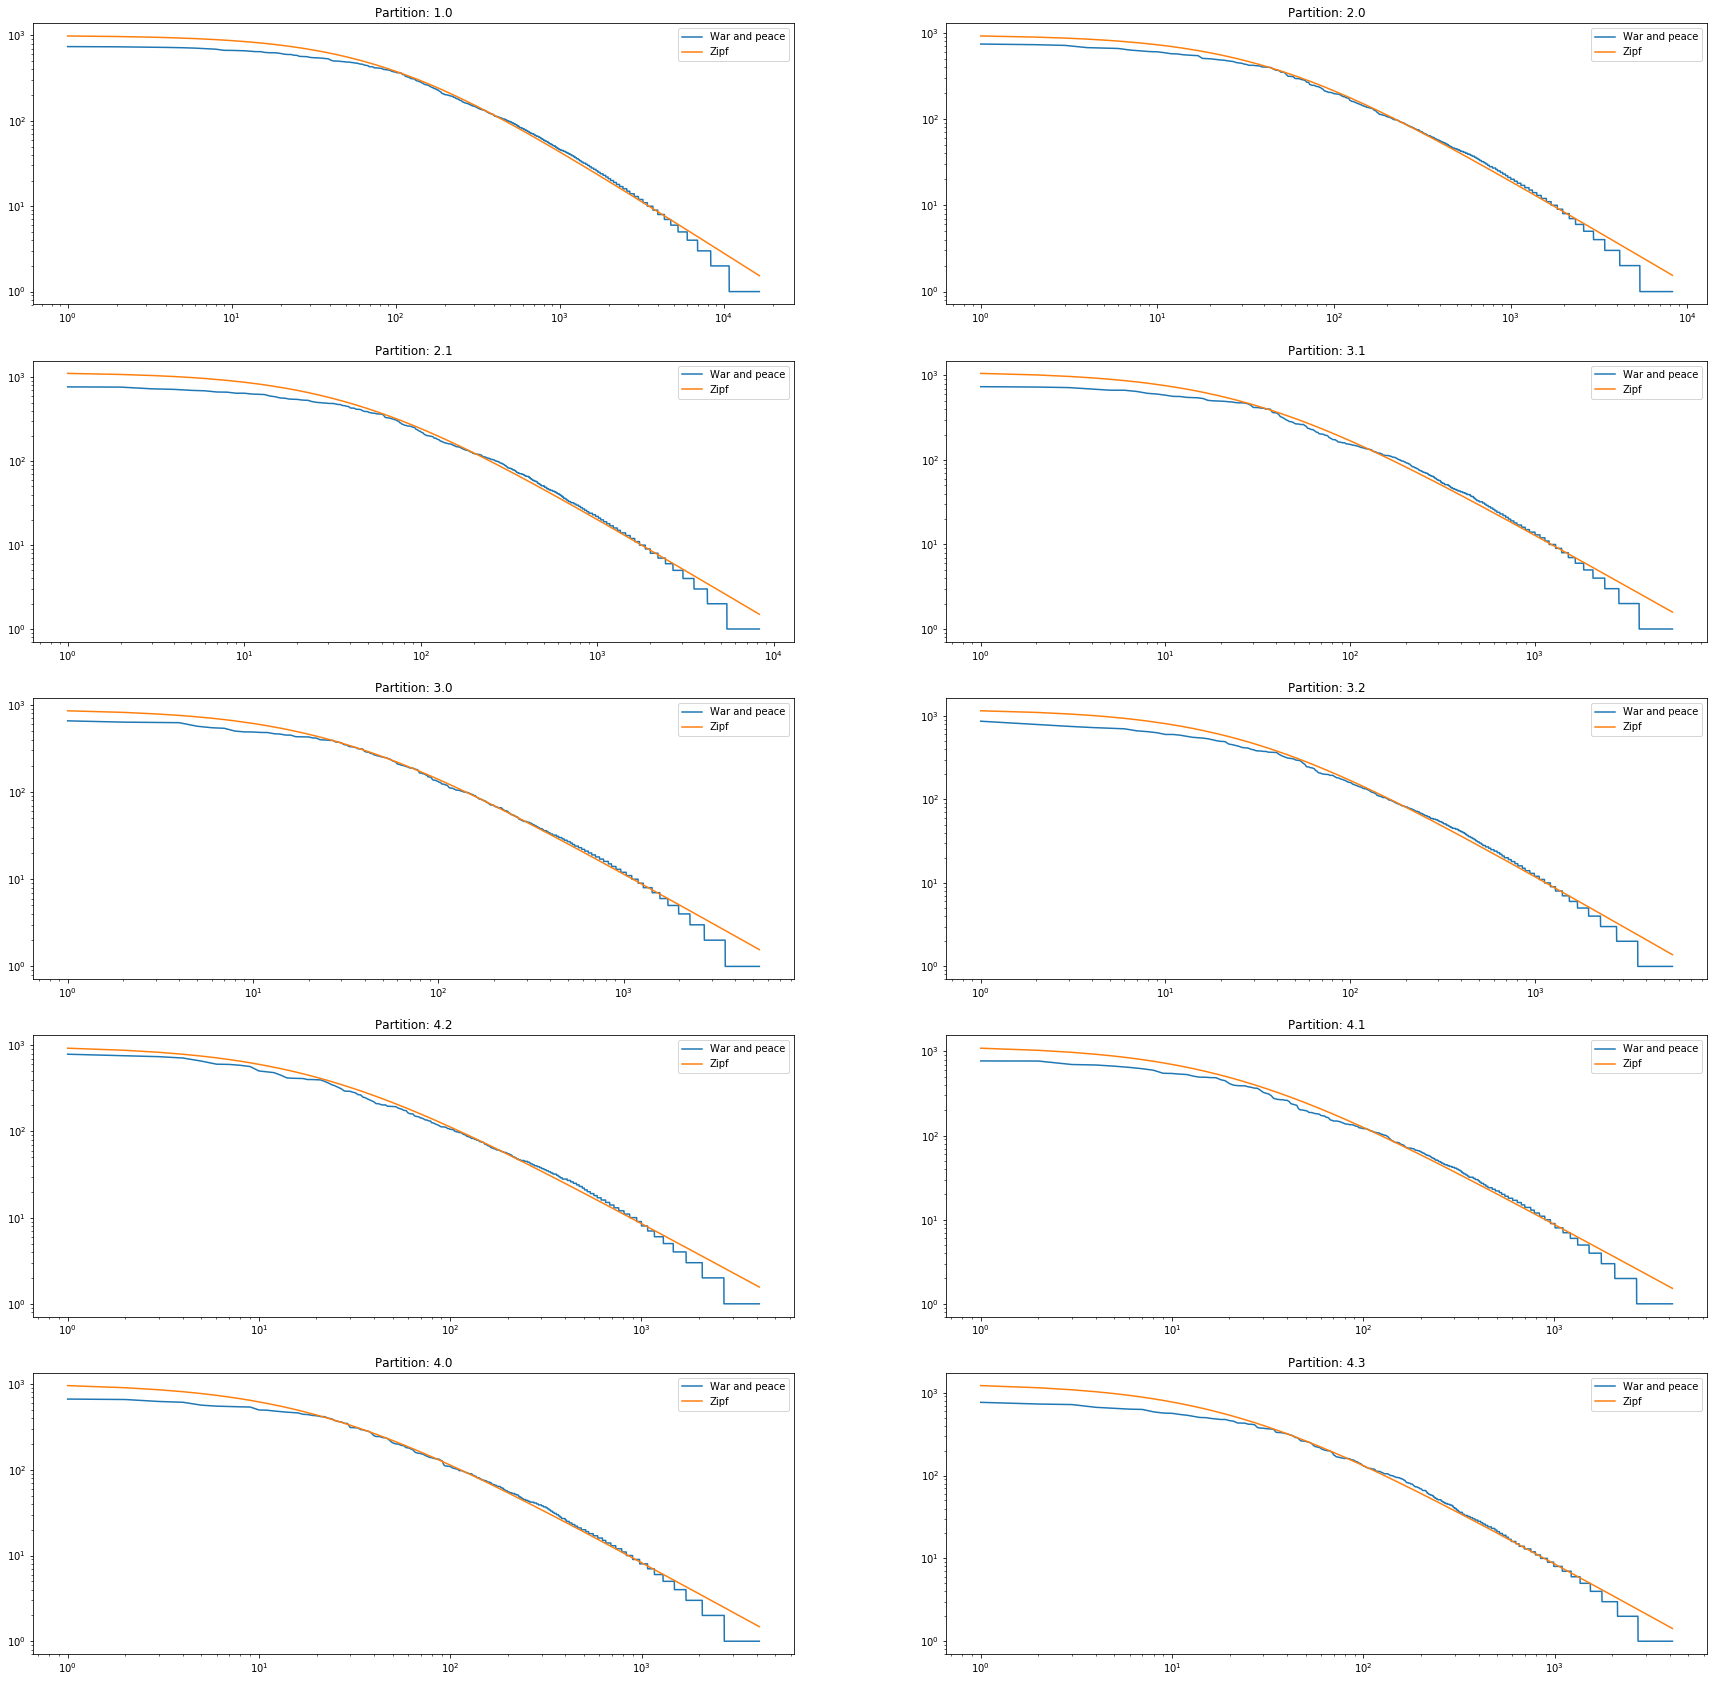

In [40]:
file = open('war_and_peace.txt', 'r')
text = file.read().lower()
words = re.sub('\W', ' ', text).split()[:500000]

to_plot = {}

tests = {'chi': chisquare_test}
paral_sizes = range(1, 5)
for name in tests:
    for ps in paral_sizes:
        hash_distributed_test(tests[name], words, paral_size=ps)
        
plt.figure(figsize=(30,30))
for idx, (part, freq) in enumerate(to_plot.items()):
    plt.subplot(5, 2, idx+1)
    for i in range(2):
        plt.loglog(range(1, len(freq[i]) + 1), freq[i])
    plt.legend(['War and peace', 'Zipf'], loc='upper right')
    plt.title('Partition: ' + part)

# Lognormal Test

In [41]:
def test_lognormal(mean, sigma, size):
    sample = np.random.lognormal(mean=mean, sigma=sigma, size=size)
    sample = np.array(sample, dtype=np.int)
    s, alpha = parameter_estimation(sample)

    counts = get_sorted_counts(sample)
    p_value, counts, zipf_counts = chisquare_test(counts, s, alpha)
    
    print(s, alpha)
    print(p_value)

    plt.figure(figsize=(10,6))
    plt.loglog(range(1, len(counts) + 1), counts)
    plt.loglog(range(1, len(zipf_counts) + 1), zipf_counts)
    plt.legend(['Log-normal', 'Zipf'], loc='upper right')

## Lognormal passes

1.2154549373656411 75243.89485308166
1.0


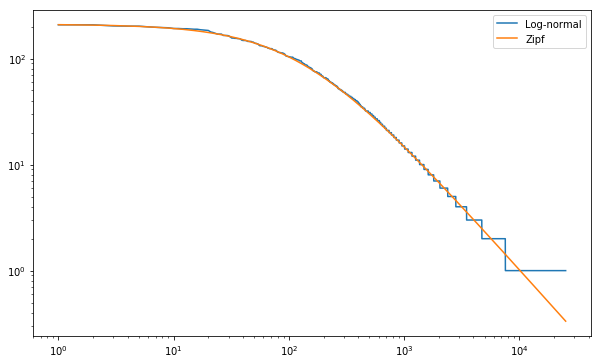

In [42]:
test_lognormal(mean = 0.3, sigma = 5, size = 500000)

## Lognoraml fails

1.0076253663590693 20174.071921644056
0.0


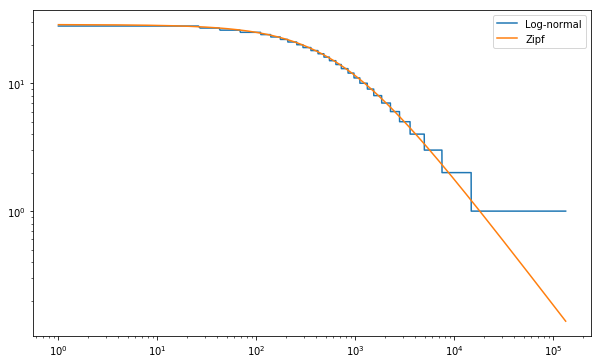

In [43]:
test_lognormal(mean = 3, sigma = 10, size = 500000)


## Test exponential

In [44]:
sample = np.random.exponential(scale=1.0 / 0.125, size=100000)
sample = np.array(sample, dtype=np.int)
s, alpha = parameter_estimation(sample)

counts = get_sorted_counts(sample)

print(s, alpha)
print(chisquare_test(counts, s, alpha)[0])

3.9773104755586512 143118084.00049636
0.0
